In [1]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

import gym
from gym import utils
from gym.envs.toy_text import discrete
import pprint
pp = pprint.PrettyPrinter(indent=4)

from collections import defaultdict
from tqdm import tqdm as _tqdm
from itertools import zip_longest

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline
import matplotlib.pyplot as plt

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"


## Change the frozen lake properties
#### Hyperparameters:
* Transition probabilities
* Mean and variance reward distribution hole state
* Mean and variance reward distribution goal state

In [2]:
def update_environment(env, transprob, Gmean, Gvar, Hmean, Hvar):
    for state in env.P:
        for action, j in enumerate(env.P[state]):
            for i, transition in enumerate(env.P[state][action]):
                next_state = transition[1]
                row_curr_state, col_curr_state = divmod(state, 4)
                row_next_state, col_next_state = divmod(next_state, 4)
                reward = transition[2]
                if env.desc[row_next_state][col_next_state] == b'G' and (next_state != state):
                    reward = np.random.normal(Gmean, Gvar)
                elif env.desc[row_next_state][col_next_state] == b'H' and (next_state != state):
                    reward = np.random.normal(Hmean, Hvar)
                if i == 1:
                    env.P[state][action][i] = (transprob, transition[1], reward, transition[3])
                else:
                    env.P[state][action][i] = ((1-transprob)/2, transition[1], reward, transition[3])    


In [3]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(len(self.Q[0,:]))
        else:
            return np.argmax(self.Q[obs,:])

In [4]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [5]:
def q_learning(env, policy, Q, num_episodes, discount_factor=0.99, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    for i_episode in tqdm(range(num_episodes)):
        i = 0 # episode length
        R = 0 # episode return
        state = env.reset()
        while True:
            i += 1 # update episode length
    
            a = policy.sample_action(state)
            (next_state, reward, done, _) = env.step(a)
            max_a = np.max(Q[next_state,:])
            Q[state][a] = Q[state][a] + alpha*(reward + discount_factor*max_a - Q[state][a])
            R += reward # update episode return
            
            state = next_state
            policy.Q = Q
            if done:
                break
                
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

## Testing hyperparameters

Transition probability: 0.8

(0.8, 0.1, 0.5, -0.1, 0.5)

C:\Users\Barba\Anaconda3\envs\rlcourse\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1962.36it/s]


100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2820.26it/s]


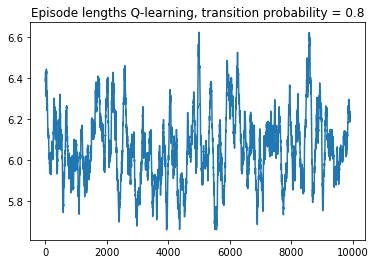

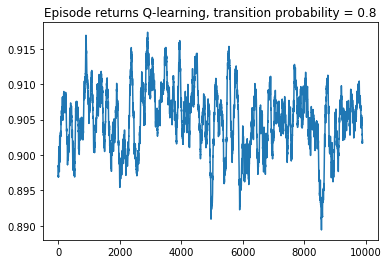

0

In [6]:
env = gym.make('FrozenLake-v0').env
env.reset()

for trans_prob in [0.8]:
    update_environment(env, trans_prob, 0.1, 0.5, -0.1, 0.5)
    Q = np.zeros((env.nS, env.nA))
    policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
    Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 10000)
    
    total_len, total_return = [], []
    for i in range(100):
        Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 10000)
        total_len = [sum(n) for n in zip_longest(total_len, episode_lengths_q_learning, fillvalue=0)]
        total_return = [sum(n) for n in zip_longest(total_return, episode_returns_q_learning, fillvalue=0)]
        
    episode_lengths_q_learning = [x/100 for x in total_len]
    episode_returns_q_learning = [x/100 for x in total_return]

    n = 100
    # We will help you with plotting this time
    plt.plot(running_mean(episode_lengths_q_learning,n))
    plt.title('Episode lengths Q-learning, transition probability = '+ str(trans_prob))
    plt.show()
    plt.plot(running_mean(episode_returns_q_learning,n))
    plt.title('Episode returns Q-learning, transition probability = '+ str(trans_prob))
    plt.show()
    
env.reset()
# pp.pprint(env.P)

In [7]:
def double_q_learning(env, policy, Q, num_episodes, discount_factor=0.99, alpha=0.5):
    # Keeps track of useful statistics
    stats = []
    Q1 = np.copy(Q)
    Q2 = np.copy(Q)
    for i_episode in tqdm(range(num_episodes)):
        i = 0 # episode length
        R = 0 # episode return
        
        state = env.reset()
        while True:
            i += 1 # update episode length
                
            a = policy.sample_action(state)
            (next_state, reward, done, _) = env.step(a)
            if np.random.choice([True, False]):
                argmax_a = np.argmax(Q1[next_state,:])
                Q1[state][a] = Q1[state][a] + alpha*(reward + discount_factor*Q2[next_state][argmax_a] - Q1[state][a])
                R += reward # update episode return
            else:
                argmax_a = np.argmax(Q2[next_state,:])
                Q2[state][a] = Q2[state][a] + alpha*(reward + discount_factor*Q1[next_state][argmax_a] - Q2[state][a])
                R += reward # update episode return
            
            state = next_state
            
            policy.Q = (Q1+Q2)/2
            if done:
                break
        
        Q = (Q1+Q2)/2
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [9]:
### for trans_prob in [0.8]:
    update_environment(env, trans_prob, 0.1, 0.5, -0.1, 0.5)
    Q = np.zeros((env.nS, env.nA))
    policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
    
    total_len, total_return = [], []
    runs = 100
    for i in range(runs):
        Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 10000)
        total_len = [sum(n) for n in zip_longest(total_len, episode_lengths_double_q_learning, fillvalue=0)]
        total_return = [sum(n) for n in zip_longest(total_return, episode_returns_double_q_learning, fillvalue=0)]
        
    episode_lengths_double_q_learning = [x/runs for x in total_len]
    episode_returns_double_q_learning = [x/runs for x in total_return]
    
    n = 100
    # We will help you with plotting this time
    plt.plot(running_mean(episode_lengths_double_q_learning,n))
    plt.title('Episode lengths double_Q-learning, transition probability = '+ str(trans_prob))
    plt.show()
    plt.plot(running_mean(episode_returns_double_q_learning,n))
    plt.title('Episode returns double_Q-learning, transition probability =  '+ str(trans_prob))
    plt.show()

env.reset()

IndentationError: unexpected indent (Temp/ipykernel_15308/2151198391.py, line 2)